## Phase 3: AQI Category Classification

### Objective
The objective of Phase 3 is to reformulate the air quality prediction task as a **classification problem**.  
Instead of predicting continuous AQI values, this phase focuses on predicting **air quality categories (`AQI_Bucket`)**, which represent discrete pollution severity levels.

This formulation aligns more closely with real-world applications such as public health advisories, regulatory decision-making, and environmental monitoring systems, where categorical air quality labels are often more actionable than exact AQI values.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/city_day_data.csv')

df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,1/1/2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,1/2/2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,1/3/2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,1/4/2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,1/5/2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [9]:
df.shape

(29531, 16)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


## Dataset Overview

The dataset used in Phase 3 is the same city-day air quality dataset used in previous phases.  
It contains daily pollutant measurements recorded across multiple cities, including particulate matter, gaseous pollutants, and volatile organic compounds (VOCs).

Key characteristics of the dataset:
- Temporal granularity: Daily observations
- Spatial granularity: City-level measurements
- Pollutants include PM2.5, PM10, NO, NO₂, NOx, CO, SO₂, O₃, Benzene, Toluene
- Target variable in this phase: `AQI_Bucket` (categorical)

While the raw dataset remains unchanged, the **modeling objective and target variable differ** from earlier regression-based phases.


In [11]:
df.isnull().sum()

,0
City,0
Date,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
NH3,10328
CO,2059
SO2,3854


## Feature Engineering Strategy

To reduce dimensionality and improve interpretability, pollutant features were grouped into three domain-driven indices based on chemical similarity and environmental relevance:

- **PM_Index**: Combines particulate matter indicators (PM2.5, PM10)
- **Gas_Index**: Aggregates gaseous pollutants (NO, NO₂, NOx, CO, SO₂, O₃)
- **VOC_Index**: Represents volatile organic compounds (Benzene, Toluene)

This abstraction transforms multiple raw pollutant measurements into higher-level indicators that reflect broader pollution sources and behaviors.



## Target Variable Definition

The target variable for Phase 3 is `AQI_Bucket`, a categorical representation of air quality levels.

`AQI_Bucket` discretizes continuous AQI values into predefined air quality categories, enabling multi-class classification.  
This transformation shifts the problem from numerical prediction to categorical risk assessment, which is more suitable for public communication and policy-driven applications.


In [12]:
target = 'AQI_Bucket'

pm_pollutants = ['PM2.5', 'PM10']
gas_pollutants = ['NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']
voc_pollutants = ['Benzene', 'Toluene']

all_pollutants = pm_pollutants + gas_pollutants + voc_pollutants

In [13]:
df_p2 = df[all_pollutants + [target]]

df_p2.head()

,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,AQI_Bucket
0,NaN,NaN,0.92,18.22,17.15,0.92,27.64,133.36,0.00,0.02,NaN
1,NaN,NaN,0.97,15.69,16.46,0.97,24.55,34.06,3.68,5.50,NaN
2,NaN,NaN,17.40,19.30,29.70,17.40,29.07,30.70,6.80,16.40,NaN
3,NaN,NaN,1.70,18.48,17.97,1.70,18.59,36.08,4.43,10.14,NaN
4,NaN,NaN,22.10,21.42,37.76,22.10,39.33,39.31,7.01,18.89,NaN


In [14]:
df_p2.isnull().sum()

,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
CO,2059
SO2,3854
O3,4022
Benzene,5623
Toluene,8041


In [15]:
df_p2 = df_p2.dropna(subset=[target])

df_p2.shape

(24850, 11)

In [16]:
for col in all_pollutants:
    median_value = df_p2[col].median()
    df_p2[col] = df_p2[col].fillna(median_value)

In [17]:
df_p2.isnull().sum()

,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
CO,0
SO2,0
O3,0
Benzene,0
Toluene,0


## Data Cleaning and Preprocessing

Missing values were handled after feature selection to ensure consistency across engineered features.

- Rows with missing target labels (`AQI_Bucket`) were removed.
- Missing pollutant values were imputed using **median imputation**, which is robust to skewed distributions and outliers.

Normalization was applied **only to input features**, not to the target variable.
Since `AQI_Bucket` is categorical, no scaling or transformation was applied to the target.


## Feature Scaling and Index Construction

Before constructing pollutant indices, individual pollutant features were standardized using Z-score normalization.

This ensures that:
- Pollutants within the same index contribute equally
- Scale dominance (e.g., PM10 overpowering PM2.5) is avoided

After normalization:
- PM_Index, Gas_Index, and VOC_Index were computed as the mean of their respective normalized pollutant groups.

No further normalization was applied after index construction.


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_p2_scaled = df_p2.copy()

df_p2_scaled[all_pollutants] = scaler.fit_transform(df_p2[all_pollutants])

In [19]:
df_p2_scaled['PM_Index'] = df_p2_scaled[pm_pollutants].mean(axis=1)

df_p2_scaled['Gas_Index'] = df_p2_scaled[gas_pollutants].mean(axis=1)

df_p2_scaled['VOC_Index'] = df_p2_scaled[voc_pollutants].mean(axis=1)

In [20]:
features_p2 = ['PM_Index', 'Gas_Index', 'VOC_Index']

X = df_p2_scaled[features_p2]
y = df_p2_scaled[target]

X.head(), y.head()

(    PM_Index  Gas_Index  VOC_Index
 28  0.025449   0.576848  -0.325674
 29 -0.000964   1.115187  -0.325002
 30  0.116887   1.830487  -0.318006
 31  0.449808   2.679544  -0.311813
 32  0.789712   2.754626  -0.309254,
 28         Poor
 29    Very Poor
 30       Severe
 31       Severe
 32       Severe
 Name: AQI_Bucket, dtype: object)

## Exploratory Data Analysis (EDA)

Exploratory analysis was conducted to understand the distribution of air quality categories and their relationship with engineered features.

Key focus areas:
- Distribution of `AQI_Bucket` classes
- Potential class imbalance
- Relationship between pollution indices and air quality categories


In [21]:
y.value_counts()

,count
AQI_Bucket,
Moderate,8829
Satisfactory,8224
Poor,2781
Very Poor,2337
Good,1341
Severe,1338


In [22]:
y.value_counts(normalize=True)*100

,proportion
AQI_Bucket,
Moderate,35.529175
Satisfactory,33.094567
Poor,11.191147
Very Poor,9.404427
Good,5.396378
Severe,5.384306


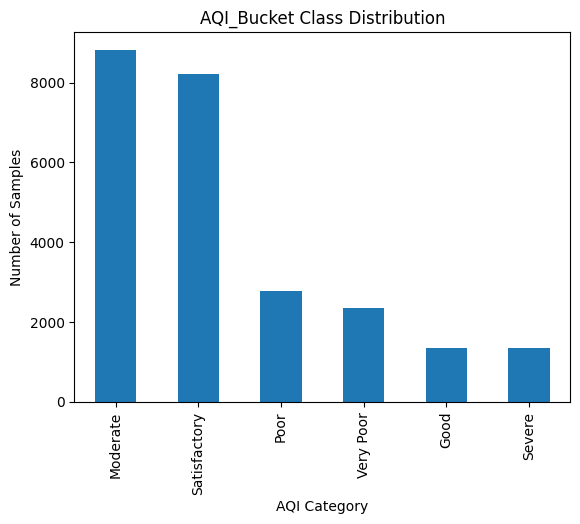

In [23]:
import matplotlib.pyplot as plt

y.value_counts().plot(kind='bar')
plt.title('AQI_Bucket Class Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Samples')
plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [27]:
y_train.value_counts(normalize=True)*100


,proportion
AQI_Bucket,
Moderate,35.526104
Satisfactory,33.095455
Poor,11.192789
Very Poor,9.406020
Good,5.397864
Severe,5.381767


In [28]:
y_test.value_counts(normalize=True)*100


,proportion
AQI_Bucket,
Moderate,35.538387
Satisfactory,33.091904
Poor,11.186222
Very Poor,9.399646
Severe,5.391920
Good,5.391920


## Modeling Approach

Phase 3 frames the problem as a **multi-class classification task**.

Classification models were trained to predict `AQI_Bucket` using the engineered features:
- PM_Index
- Gas_Index
- VOC_Index

The dataset was split into training and testing subsets using an 80–20 split to ensure fair evaluation on unseen data.


## Evaluation Metrics

Model performance was evaluated using classification-appropriate metrics:

- **Accuracy**: Overall correctness of predictions
- **Precision**: Reliability of predicted classes
- **Recall**: Ability to capture actual class instances
- **F1-Score**: Balance between precision and recall
- **Confusion Matrix**: Class-wise error analysis

These metrics provide a comprehensive understanding of both overall and per-class model behavior.


## Model 1: Logistic Regression (Baseline Classifier)

Logistic Regression was used as the baseline classification model for Phase 3.  
It provides a linear decision boundary in the engineered feature space and serves as a reference point for evaluating more complex models.

### Why Logistic Regression?
- Simple and interpretable baseline
- Suitable for multi-class classification
- Helps assess whether linear separability exists between AQI categories

The model was trained using:
- Input features: PM_Index, Gas_Index, VOC_Index
- Target variable: AQI_Bucket


In [29]:
log_clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [30]:
y_pred_log = log_clf.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log, average='macro')

acc_log, f1_log


(0.5750845002414292, 0.5163577605623667)

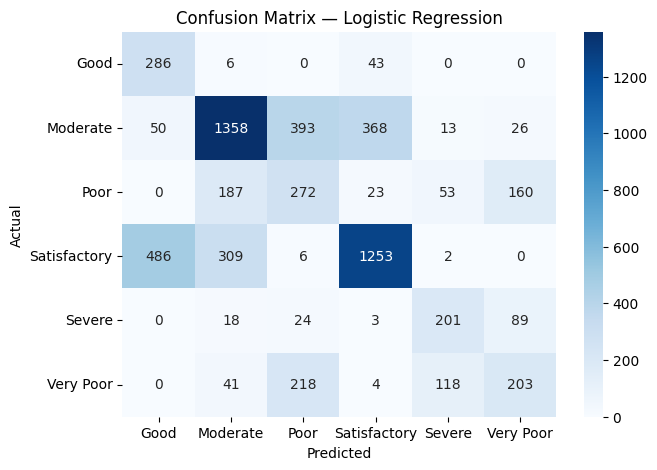

In [36]:
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(7,5))
sns.heatmap(
    cm_log,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=log_clf.classes_,
    yticklabels=log_clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


In [37]:
print(classification_report(y_test, y_pred_log))


              precision    recall  f1-score   support

        Good       0.35      0.85      0.49       335
    Moderate       0.71      0.62      0.66      2208
        Poor       0.30      0.39      0.34       695
Satisfactory       0.74      0.61      0.67      2056
      Severe       0.52      0.60      0.56       335
   Very Poor       0.42      0.35      0.38       584

    accuracy                           0.58      6213
   macro avg       0.51      0.57      0.52      6213
weighted avg       0.62      0.58      0.59      6213



### Logistic Regression - Performance Analysis

The confusion matrix indicates that Logistic Regression performs reasonably well for **lower and mid-range AQI categories**, but struggles to clearly separate **adjacent or extreme AQI buckets**.

Key observations:
- Most misclassifications occur between neighboring AQI categories
- Performance degrades for higher pollution buckets
- Indicates that AQI categories are **not linearly separable**

This behavior is expected given the linear nature of the model and the non-linear relationships between pollutants and air quality severity.


## Model 2: Decision Tree Classifier

The Decision Tree model was introduced to capture **non-linear relationships** between pollution indices and AQI categories.

Unlike Logistic Regression, Decision Trees:
- Do not assume linearity
- Automatically learn feature thresholds
- Can model complex decision boundaries

This makes them well-suited for environmental data where pollutant interactions are rarely linear.


In [39]:
dt_clf = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42
)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=50, random_state=42)

In [40]:
y_pred_dt = dt_clf.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='macro')

acc_dt, f1_dt

(0.6079188797682279, 0.5742490787199409)

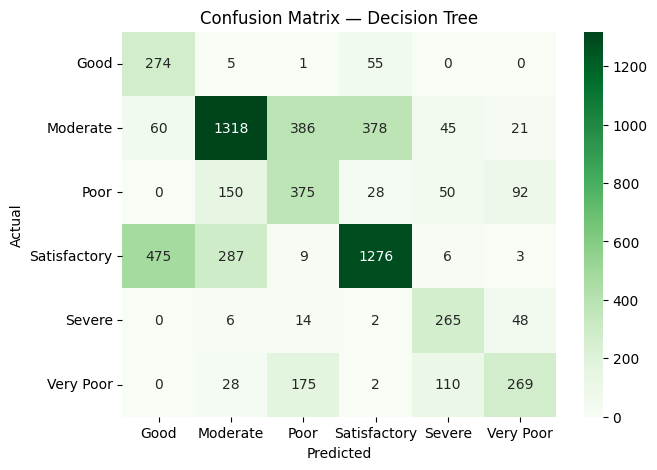

In [41]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(7,5))
sns.heatmap(
    cm_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=dt_clf.classes_,
    yticklabels=dt_clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Decision Tree")
plt.show()

In [42]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

        Good       0.34      0.82      0.48       335
    Moderate       0.73      0.60      0.66      2208
        Poor       0.39      0.54      0.45       695
Satisfactory       0.73      0.62      0.67      2056
      Severe       0.56      0.79      0.65       335
   Very Poor       0.62      0.46      0.53       584

    accuracy                           0.61      6213
   macro avg       0.56      0.64      0.57      6213
weighted avg       0.65      0.61      0.62      6213



### Decision Tree - Performance Analysis

The Decision Tree shows improved flexibility compared to Logistic Regression, particularly in capturing non-linear patterns.

Key observations:
- Better class separation than Logistic Regression
- Improved recall for higher AQI categories
- Increased variance and sensitivity to data splits

However, the confusion matrix reveals signs of **overfitting**, with some classes predicted very confidently while others remain unstable.  
This highlights the trade-off between model flexibility and generalization.


## Model 3: Random Forest Classifier

Random Forest was used as the final and most robust model in Phase 3.

It is an ensemble method that:
- Combines multiple decision trees
- Reduces overfitting through averaging
- Improves generalization and stability

Random Forest is particularly effective for structured, noisy, real-world datasets like air quality measurements.


In [44]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


In [45]:
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

acc_rf, f1_rf


(0.6479961371318204, 0.6149522391808531)

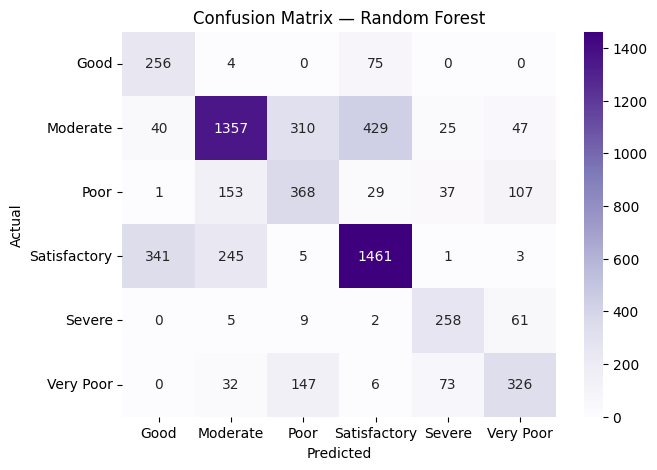

In [46]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7,5))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=rf_clf.classes_,
    yticklabels=rf_clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Random Forest")
plt.show()


In [47]:
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

        Good       0.40      0.76      0.53       335
    Moderate       0.76      0.61      0.68      2208
        Poor       0.44      0.53      0.48       695
Satisfactory       0.73      0.71      0.72      2056
      Severe       0.65      0.77      0.71       335
   Very Poor       0.60      0.56      0.58       584

    accuracy                           0.65      6213
   macro avg       0.60      0.66      0.61      6213
weighted avg       0.67      0.65      0.65      6213



### Random Forest - Performance Analysis

Random Forest achieved the most balanced and reliable performance among the three models.

Key observations:
- Improved overall accuracy and F1-score
- Better handling of extreme AQI categories
- Reduced variance compared to a single Decision Tree
- More stable confusion matrix with fewer erratic misclassifications

The ensemble approach allows the model to capture complex pollutant interactions while maintaining robustness across AQI categories.


## Model Comparison Summary

Across the three classification models:

- **Logistic Regression** provided a strong baseline but was limited by linear decision boundaries.
- **Decision Tree** captured non-linear patterns but showed signs of overfitting.
- **Random Forest** offered the best balance between flexibility and generalization.

Overall, model performance improved as model complexity increased, confirming that AQI category prediction benefits from non-linear and ensemble-based approaches.


## Assumptions and Limitations

### Assumptions
- Engineered pollution indices adequately summarize underlying pollutant behavior
- AQI_Bucket labels accurately represent discrete air quality risk levels
- Daily pollutant measurements are sufficient for category-level prediction

### Limitations
- Temporal dependencies (seasonality, trends) were not modeled
- City-specific geographic effects were ignored
- Class imbalance affects prediction reliability for rare AQI categories
- Extreme pollution events remain difficult to classify accurately
- Feature engineering, while improving interpretability, reduces raw variance

These limitations indicate that while the models are suitable for general air quality categorization, further refinement is required for high-risk scenario prediction.


## Conclusion

Phase 3 successfully reframed air quality prediction as a **multi-class classification problem**, aligning the modeling objective with real-world decision-making needs.

Through progressive modeling:
- Logistic Regression established a linear baseline
- Decision Tree captured non-linear pollutant effects
- Random Forest delivered the most robust and stable performance

While classification reduces numerical precision compared to regression, it significantly improves interpretability and usability for public health applications.

This phase demonstrates that **structured feature engineering combined with ensemble learning** is a powerful approach for environmental risk classification.
